<a href="https://colab.research.google.com/github/delte1821/ML-SERS/blob/master/ML_SERS_v2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost

In [46]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import tensorflow as tf
from scipy import stats
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, label_binarize
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def initialize_paths(file_path):
    figure_path = os.path.join(file_path, "Figures")
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    return figure_path

In [5]:
def load_data(file_path):
    df = pd.read_excel(file_path, header=None)
    materials = df.iloc[0, :].astype(int)  # Ensure materials are integers
    concentrations = df.iloc[1, :].astype(float)
    data = df.iloc[2:, :].values
    return data, materials, concentrations

In [6]:
def filter_by_material(data, materials, concentrations, material_type):
    indices = materials == material_type
    filtered_data = data[:, indices]
    filtered_concentrations = concentrations[indices]

    return filtered_data, filtered_concentrations

In [7]:
def preprocess_data(data):
    nsamples, nx, ny = data.shape
    data_2d = data.reshape((nsamples, nx * ny))
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_2d)
    data_reshaped = data_scaled.reshape(nsamples, nx, ny)
    return data_reshaped

In [8]:
def augment_data(data, labels, num_augmented_samples=20):
    augmented_data = []
    augmented_labels = []
    original_len = len(data)
    for sample, label in zip(data, labels):
        augmented_data.append(sample)
        augmented_labels.append(label)
        for _ in range(num_augmented_samples):
            noise = np.random.normal(0, 0.1, sample.shape)
            augmented_sample = sample + noise

            # Additional augmentations
            scale_factor = np.random.uniform(0.9, 1.1)
            augmented_sample = augmented_sample * scale_factor

            shift_value = np.random.uniform(-0.1, 0.1, sample.shape)
            augmented_sample = augmented_sample + shift_value

            augmented_data.append(augmented_sample)
            augmented_labels.append(label)
    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)
    print(f"Original data size: {original_len}, Augmented data size: {len(augmented_data)}")
    return augmented_data, augmented_labels


In [9]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(16, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(50, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, kernel_regularizer=l2(0.01))  # Output layer for concentration prediction
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [10]:
def build_nn_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [22]:
def train_nn_regression(X_train, y_train, X_val, y_val, epochs=100, batch_size=32, use_early_stopping=True):
    model = build_nn_model((X_train.shape[1],))

    # Early stopping callback
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)] if use_early_stopping else []

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return model, mse, r2, history

In [21]:
def train_and_validate(data, materials, concentrations, material_types, display=True, figure_path=None, epochs=200, batch_size=128, num_augmented_samples=200, use_early_stopping=True, patience=20):
    results = {}
    fig_counter = 1

    for mat_type in material_types:
        X, y = filter_by_material(data, materials, concentrations, mat_type)

        # Split the data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X.T, y, test_size=0.2, random_state=42)

        # Data augmentation for training data only
        X_train_augmented, y_train_augmented = augment_data(X_train, y_train, num_augmented_samples)

        # Ensure X and y have consistent length
        assert X_train_augmented.shape[0] == len(y_train_augmented), "Inconsistent number of samples between data and labels"

        # Preprocess the training and validation data
        X_train_augmented = preprocess_data(X_train_augmented.reshape(X_train_augmented.shape[0], X_train_augmented.shape[1], 1))
        X_val = preprocess_data(X_val.reshape(X_val.shape[0], X_val.shape[1], 1))

        # Reshape back to 2D for regression models
        X_train_2d = X_train_augmented.reshape(X_train_augmented.shape[0], -1)
        X_val_2d = X_val.reshape(X_val.shape[0], -1)

        # Define and train multiple regression models
        models = {
            'Ridge': Ridge(alpha=1.0),
            'Lasso': Lasso(alpha=1.0),
            'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror'),
            'NeuralNetwork': None  # Will be created separately
        }

        best_model = None
        best_r2 = -np.inf
        best_name = ""

        for name, model in models.items():
            if name == 'NeuralNetwork':
                model, mse, r2, history = train_nn_regression(X_train_2d, y_train_augmented, X_val_2d, y_val, epochs=epochs, batch_size=batch_size, use_early_stopping=use_early_stopping)
            else:
                model.fit(X_train_2d, y_train_augmented)
                y_pred = model.predict(X_val_2d)
                mse = mean_squared_error(y_val, y_pred)
                r2 = r2_score(y_val, y_pred)

            print(f"{name} Regression MSE: {mse}, R2: {r2}")

            if r2 > best_r2:
                best_r2 = r2
                best_model = model
                best_name = name

        print(f"Best model: {best_name} with R2: {best_r2}")
        results[mat_type] = (best_model, best_r2)

        # Save the best model's predictions and plots
        if display:
            y_pred = best_model.predict(X_val_2d) if best_name != 'NeuralNetwork' else best_model.predict(X_val_2d).flatten()
            plot_predictions(y_val, y_pred, mat_type, fig_counter, figure_path)
            if best_name == 'NeuralNetwork':
                plot_training_history(history, mat_type, fig_counter, figure_path)

        fig_counter += 1
    return results

In [13]:
def plot_predictions(y_true, y_pred, material_type, fig_counter, figure_path):
    material_name = "IL6" if material_type == 1 else "TNF" if material_type == 2 else "Control"
    fig_filename = os.path.join(figure_path, f'{material_name}_LR_{fig_counter}.png')
    # Check if file exists and increment counter if necessary
    while os.path.exists(fig_filename):
        fig_counter += 1
        fig_filename = os.path.join(figure_path, f'{material_name}_LR_{fig_counter}.png')

    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, c='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Concentrations')
    plt.ylabel('Predicted Concentrations')
    plt.title(f'Actual vs Predicted Concentrations for {material_name}')
    r2 = r2_score(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, fontsize=18, verticalalignment='top')
    plt.tight_layout()
    plt.savefig(fig_filename)
    plt.show()

In [14]:
def plot_training_history(history, material_type, fig_counter, figure_path):
    material_name = "IL6" if material_type == 1 else "TNF" if material_type == 2 else "Control"
    fig_filename = os.path.join(figure_path, f'{material_name}_TH_{fig_counter}.png')
    # Check if file exists and increment counter if necessary
    while os.path.exists(fig_filename):
        fig_counter += 1
        fig_filename = os.path.join(figure_path, f'{material_name}_TH_{fig_counter}.png')

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Epoch vs Loss for {material_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fig_filename)
    plt.show()

In [63]:
def classify_materials(data, materials, display=True, figure_path=None, validation_size=0.2, n_components=10, num_augmented_samples=20):
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(data.T, materials, test_size=validation_size, random_state=42)

    # Data augmentation for training data only
    X_train_augmented, y_train_augmented = augment_data(X_train, y_train, num_augmented_samples)
    X_train_augmented = X_train_augmented.T  # Transpose back to original shape

    # Ensure X and y have consistent length
    assert X_train_augmented.shape[1] == len(y_train_augmented), "Inconsistent number of samples between data and labels"

    print(f"Original data size: {len(y_train)}, Augmented data size: {len(y_train_augmented)}")

    # Combine augmented training data with validation data for consistent scaling
    combined_data = np.concatenate((X_train_augmented, X_val.T), axis=1)
    combined_labels = np.concatenate((y_train_augmented, y_val), axis=0)

    # Scale the combined data
    scaler = StandardScaler()
    combined_data_scaled = scaler.fit_transform(combined_data.T).T  # Scale and then transpose back to original shape

    # Apply PCA for feature extraction
    pca = PCA(n_components=n_components)
    combined_data_pca = pca.fit_transform(combined_data_scaled.T).T  # Apply PCA and then transpose back to original shape

    # Split back into training and validation sets
    X_train_pca = combined_data_pca[:, :X_train_augmented.shape[1]]
    X_val_pca = combined_data_pca[:, X_train_augmented.shape[1]:]

    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_augmented)
    y_val_encoded = le.transform(y_val)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
    class_weights_dict = dict(enumerate(class_weights))

    # Define multiple models
    models = {
        'Logistic Regression': LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'SVM': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }

    best_auroc = -np.inf
    best_model_name = None
    best_y_pred_prob = None
    best_y_pred = None
    best_cm = None

    plt.figure(figsize=(12, 8))

    label_binarized = label_binarize(y_val_encoded, classes=np.unique(y_val_encoded))

    for model_name, model in models.items():
        auroc, y_pred_prob, y_pred, cm = evaluate_classification_model(model, X_train_pca.T, y_train_encoded, X_val_pca.T, y_val_encoded)
        print(f"{model_name} - AUROC: {auroc:.4f}")
        plot_roc_curves(y_val_encoded, y_pred_prob, model_name, label_binarized)

        if auroc > best_auroc:
            best_auroc = auroc
            best_model_name = model_name
            best_y_pred_prob = y_pred_prob
            best_y_pred = y_pred
            best_cm = cm

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    if figure_path:
        plt.tight_layout()
        plt.savefig(os.path.join(figure_path, 'ROC_Curve_Comparison.png'))
    plt.show()

    print(f"Best model: {best_model_name} with AUROC: {best_auroc:.4f}")

    # Plot confusion matrix for the best model
    if display and figure_path:
        target_names = [str(label) for label in le.classes_]
        plot_confusion_matrix(best_cm, target_names, figure_path)

    # Print classification report for the best model
    print("Classification Report for the Best Model:")
    print(classification_report(y_val_encoded, best_y_pred, target_names=target_names))

    # Calculate and print specificity and sensitivity
    specificity, sensitivity = calculate_specificity_sensitivity(best_cm)

    # Save and print the sensitivity and specificity
    results_file_path = os.path.join(figure_path, 'Sensitivity_Specificity_Best_Model.txt')
    with open(results_file_path, 'w') as f:
        for i, material in enumerate(target_names):
            f.write(f"Material: {material}\n")
            f.write(f"Specificity: {specificity[i]:.2f}\n")
            f.write(f"Sensitivity: {sensitivity[i]:.2f}\n")
            f.write("\n")

    # Also print the sensitivity and specificity to the console
    for i, material in enumerate(target_names):
        print(f"Material: {material}")
        print(f"Specificity: {specificity[i]:.2f}")
        print(f"Sensitivity: {sensitivity[i]:.2f}")
        print()


In [18]:
def plot_peak_intensity(data, materials, concentrations, material_type, peak_range, figure_path=None, display=True):
    """
    Plots the peak intensity for a given material type.

    Args:
    - data: 2D array of spectral data.
    - materials: 1D array of material types.
    - concentrations: 1D array of concentrations.
    - material_type: Integer representing the material type to plot.
    - peak_range: Tuple (start, end) representing the range of indices for the peak.
    - figure_path: Path to save the plot (optional).
    - display: Boolean indicating whether to display the plot.
    """
    indices = materials == material_type
    peak_data = data[peak_range[0]:peak_range[1], indices]
    avg_peak_data = np.mean(peak_data, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(concentrations[indices], avg_peak_data, 'o-', label=f'Material {material_type}')
    plt.xlabel('Concentration')
    plt.ylabel('Average Peak Intensity')
    plt.title(f'Average Peak Intensity vs Concentration for Material {material_type}')
    plt.legend()
    plt.grid(True)

    if figure_path:
        fig_filename = os.path.join(figure_path, f'Peak_Intensity_Material_{material_type}.png')
        plt.savefig(fig_filename)
        print(f'Peak intensity plot saved to {fig_filename}')

    if display:
        plt.show()
    else:
        plt.close()


In [34]:
def calculate_multiclass_metrics(cm):
    sensitivity = []
    specificity = []
    for i in range(len(cm)):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        sensitivity.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
    return sensitivity, specificity


In [55]:
def evaluate_classification_model(model, X_train, y_train, X_val, y_val):
    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_prob = model.predict_proba(X_val)

    # Calculate AUROC
    auroc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')

    # Predict classes
    y_pred = model.predict(X_val)

    # Calculate confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    return auroc, y_pred_prob, y_pred, cm


In [61]:
def plot_roc_curves(y_val, y_pred_prob, model_name, label_binarized):
    n_classes = y_pred_prob.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val, y_pred_prob[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(label_binarized.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label=f'{model_name} micro-average ROC curve (area = {roc_auc["micro"]:.4f})')


In [69]:
import seaborn as sns

def plot_confusion_matrix(cm, target_names, figure_path):
    fig_counter = 1
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    fig_filename = os.path.join(figure_path, f'CM_{fig_counter}.png')
    while os.path.exists(fig_filename):
        fig_counter += 1
        fig_filename = os.path.join(figure_path, f'CM_{fig_counter}.png')
    plt.tight_layout()
    plt.savefig(fig_filename)
    plt.show()

In [66]:
# ============================================================================================================= #
# Paths and instantiation
file_path = "/content/drive/My Drive/Colab Notebooks/Spectra/Low"  # Update to your actual path in Google Drive
figure_path = initialize_paths(file_path)
original_file_path = os.path.join(file_path, "Combine.xlsx")
display = True
epochs = 200
batch_size = 128
num_augmented_samples=200
use_early_stopping = True
patience = 20

# Load and preprocess data
data, materials, concentrations = load_data(original_file_path)
material_types = [1, 2]  # Focusing on IL6 and TNF for example

# Set parameters
validation_size = 0.2  # Adjust validation size if necessary
n_components = 10  # Number of principal components to use

# Check data dimensions after loading
print(f"Data shape after loading: {data.shape}")
print(f"Materials shape after loading: {materials.shape}")

Data shape after loading: (1024, 232)
Materials shape after loading: (232,)


In [71]:
### Linear regression ###
# Run the train_and_validate function
results_regression = train_and_validate(data, materials, concentrations, material_types, display=display, figure_path=figure_path, epochs=epochs, batch_size=batch_size, num_augmented_samples=num_augmented_samples, use_early_stopping=use_early_stopping, patience=patience)


Original data size: 99, Augmented data size: 19899


KeyboardInterrupt: 

Original data size: 185, Augmented data size: 3885
Original data size: 185, Augmented data size: 3885
Logistic Regression - AUROC: 0.9916
Random Forest - AUROC: 0.9958
SVM - AUROC: 0.9844
Gradient Boosting - AUROC: 0.9976


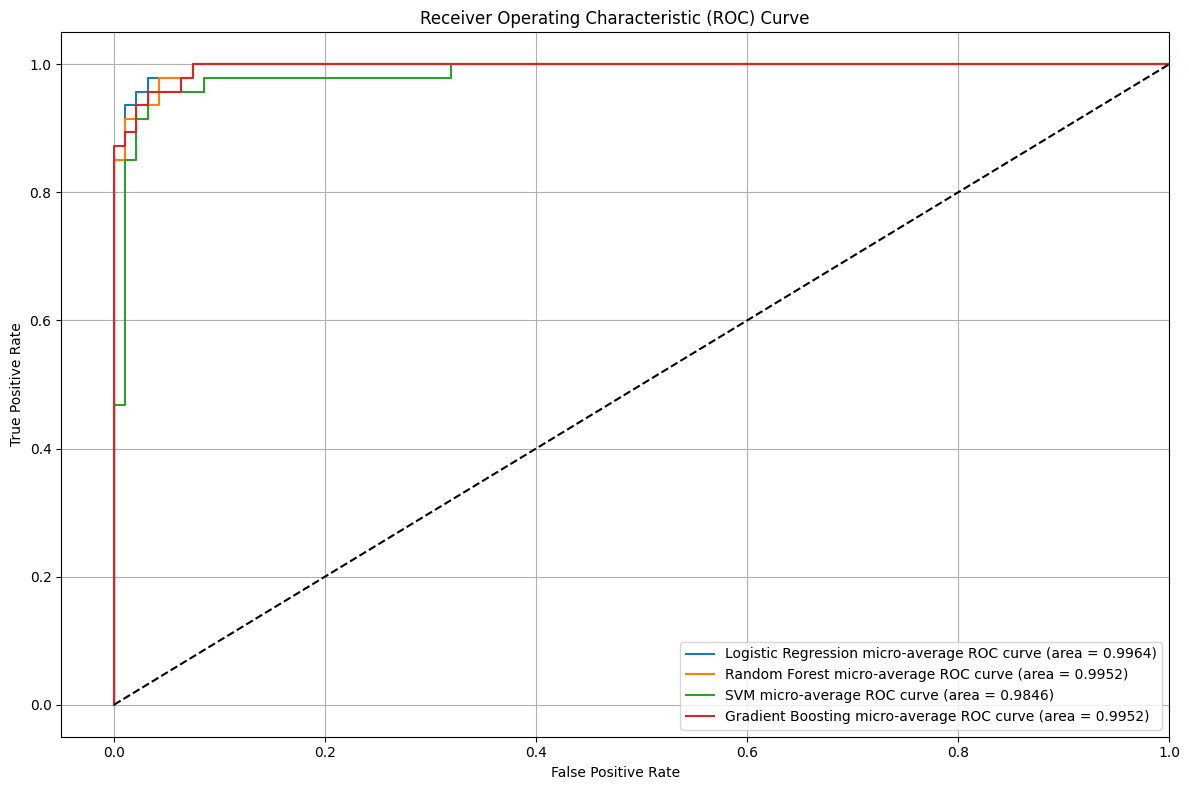

Best model: Gradient Boosting with AUROC: 0.9976


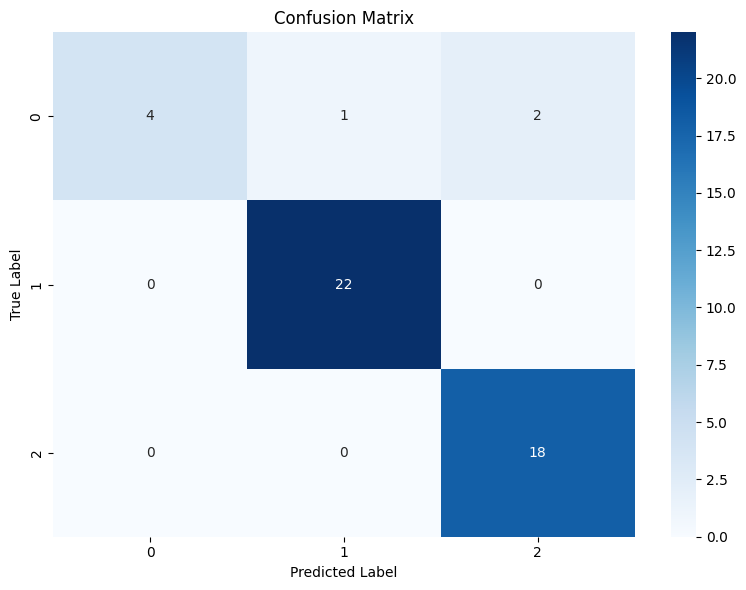

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.96      1.00      0.98        22
           2       0.90      1.00      0.95        18

    accuracy                           0.94        47
   macro avg       0.95      0.86      0.88        47
weighted avg       0.94      0.94      0.93        47

Material: 0
Specificity: 1.00
Sensitivity: 0.57

Material: 1
Specificity: 0.96
Sensitivity: 1.00

Material: 2
Specificity: 0.93
Sensitivity: 1.00



In [70]:
### Classification ###
# Set parameters
validation_size = 0.2  # Adjust validation size if necessary
n_components = 10  # Number of principal components to use

# Call classify_materials with appropriate data handling
classify_materials(data, materials, display=display, figure_path=figure_path, validation_size=validation_size, n_components=n_components, num_augmented_samples=20)